In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Dropout, Conv1D# Слои для сети
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/datasets/texts/Тексты писателей.zip' -d '/content/texts'

In [ ]:
# Запускаем все необходимые функции

def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку
  
  return (xSamples, ySamples) # Функция возвращает выборку и соответствующие векторы классов

# Создаем функцию подготовки данных
def creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100):
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

    # Преобразовываем текст в последовательность индексов согласно частотному словарю
    trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
    testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

    #Формируем обучающую и тестовую выборку
    xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
    xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

    # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest

#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
# Создаем функцию подготовки данных
def creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100):
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText)

    # Преобразовываем текст в последовательность индексов согласно частотному словарю
    trainWordIndexes = tokenizer.texts_to_sequences(trainText)
    testWordIndexes = tokenizer.texts_to_sequences(testText)

    #Формируем обучающую и тестовую выборку
    xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
    xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)

    # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist())
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest

In [ ]:
_, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(200, input_dim=15000, activation="relu"))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(Dense(6, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [ ]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               3000200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 200)               800       
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 1206      
Total params: 3,002,206
Trainable params: 3,001,806
Non-trainable params: 400
_________________________________________________________________


Epoch 1/10
120/120 [==============================] - 7s 58ms/step - loss: 0.0491 - accuracy: 0.9849 - val_loss: 0.3060 - val_accuracy: 0.9236
Epoch 2/10
120/120 [==============================] - 7s 56ms/step - loss: 4.0082e-04 - accuracy: 1.0000 - val_loss: 0.2529 - val_accuracy: 0.9242
Epoch 3/10
120/120 [==============================] - 7s 56ms/step - loss: 2.1820e-04 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.9222
Epoch 4/10
120/120 [==============================] - 7s 57ms/step - loss: 1.3152e-04 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.9206
Epoch 5/10
120/120 [==============================] - 7s 56ms/step - loss: 9.3321e-05 - accuracy: 1.0000 - val_loss: 0.2385 - val_accuracy: 0.9220
Epoch 6/10
120/120 [==============================] - 7s 56ms/step - loss: 7.1840e-05 - accuracy: 1.0000 - val_loss: 0.2351 - val_accuracy: 0.9240
Epoch 7/10
120/120 [==============================] - 7s 57ms/step - loss: 5.6511e-05 - accuracy: 1.0000 - val_loss: 0.237

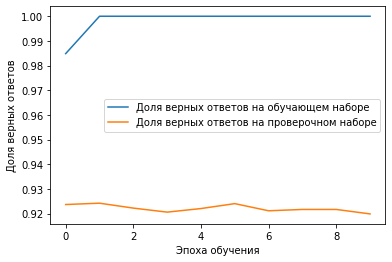

In [ ]:
#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model.fit(xTrain01, yTrain, epochs=10, batch_size=128, validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
data = [[1, 200, 'relu', 15000, None, round(history.history['val_accuracy'][-1], 3)]]
data

[[1, 200, 'relu', 15000, None, 0.92]]

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

4358

In [ ]:
# 1
maxWordsCountList = [10,1000,10000,25000]
for i in maxWordsCountList:
    gc.collect()
    # Подготавливаем данные
    _, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = i, xLen = 1000, step = 100)
    # Создаем сеть
    model01 = Sequential()
    model01.add(Dense(200, input_dim=i, activation="relu")) # Указываем входной размер 
    model01.add(Dropout(0.25))
    model01.add(BatchNormalization())
    model01.add(Dense(6, activation='softmax'))

    model01.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy']
    history = model01.fit(xTrain01, yTrain, epochs=10, batch_size=128, validation_data=(xTest01, yTest))
                      
    data = data + [[1, 200, 'relu', i, None, round(history.history['val_accuracy'][-1], 3)]]


Epoch 1/10
24/24 [==============================] - 0s 5ms/step - loss: 1.8878 - accuracy: 0.2460 - val_loss: 1.7400 - val_accuracy: 0.3401
Epoch 2/10
24/24 [==============================] - 0s 2ms/step - loss: 1.6903 - accuracy: 0.2837 - val_loss: 1.6800 - val_accuracy: 0.3401
Epoch 3/10
24/24 [==============================] - 0s 2ms/step - loss: 1.5820 - accuracy: 0.3241 - val_loss: 1.6653 - val_accuracy: 0.3401
Epoch 4/10
24/24 [==============================] - 0s 2ms/step - loss: 1.5378 - accuracy: 0.3429 - val_loss: 1.6736 - val_accuracy: 0.3401
Epoch 5/10
24/24 [==============================] - 0s 2ms/step - loss: 1.4979 - accuracy: 0.3488 - val_loss: 1.6738 - val_accuracy: 0.3401
Epoch 6/10
24/24 [==============================] - 0s 2ms/step - loss: 1.4918 - accuracy: 0.3606 - val_loss: 1.6680 - val_accuracy: 0.3401
Epoch 7/10
24/24 [==============================] - 0s 2ms/step - loss: 1.4761 - accuracy: 0.3672 - val_loss: 1.6655 - val_accuracy: 0.3401
Epoch 8/10
24/24 [==

In [ ]:
# 2.1
_, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = 20000, xLen = 1000, step = 100)
neurons_list = [10, 50, 100, 500, 1000, 2000]

for i in neurons_list:
    gc.collect()
    # Создаем сеть
    model01 = Sequential()
    model01.add(Dense(i, input_dim=20000, activation="relu"))
    model01.add(Dropout(0.25))
    model01.add(BatchNormalization())
    model01.add(Dense(6, activation='softmax'))

    model01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model01.fit(xTrain01, yTrain, epochs=10, batch_size=128, validation_data=(xTest01, yTest))
    data = data + [[1, i, 'relu', 20000, None, round(history.history['val_accuracy'][-1], 3)]]

Epoch 1/10
124/124 [==============================] - 2s 14ms/step - loss: 0.5827 - accuracy: 0.8859 - val_loss: 0.7303 - val_accuracy: 0.8373
Epoch 2/10
124/124 [==============================] - 1s 11ms/step - loss: 0.2391 - accuracy: 0.9660 - val_loss: 0.5577 - val_accuracy: 0.8932
Epoch 3/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1657 - accuracy: 0.9698 - val_loss: 0.4874 - val_accuracy: 0.8960
Epoch 4/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1281 - accuracy: 0.9738 - val_loss: 0.4248 - val_accuracy: 0.9069
Epoch 5/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1067 - accuracy: 0.9781 - val_loss: 0.3990 - val_accuracy: 0.9039
Epoch 6/10
124/124 [==============================] - 1s 11ms/step - loss: 0.0899 - accuracy: 0.9812 - val_loss: 0.3830 - val_accuracy: 0.9084
Epoch 7/10
124/124 [==============================] - 1s 11ms/step - loss: 0.0794 - accuracy: 0.9833 - val_loss: 0.3808 - val_accuracy: 0.8965

In [ ]:
# 2.2
for i in neurons_list:
    gc.collect()
    # Создаем сеть
    model01 = Sequential()
    model01.add(Dense(i, input_dim=20000, activation="relu"))
    model01.add(Dense(i, activation="relu"))               
    model01.add(Dropout(0.25))
    model01.add(BatchNormalization())
    model01.add(Dense(6, activation='softmax'))

    model01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model01.fit(xTrain01, yTrain, epochs=10, batch_size=128, validation_data=(xTest01, yTest))
    data = data + [[2, i, 'relu', 20000, None, round(history.history['val_accuracy'][-1], 3)]]

Epoch 1/10
124/124 [==============================] - 2s 13ms/step - loss: 0.7387 - accuracy: 0.8001 - val_loss: 1.0653 - val_accuracy: 0.6567
Epoch 2/10
124/124 [==============================] - 1s 12ms/step - loss: 0.3194 - accuracy: 0.9333 - val_loss: 0.8526 - val_accuracy: 0.7571
Epoch 3/10
124/124 [==============================] - 1s 11ms/step - loss: 0.2185 - accuracy: 0.9609 - val_loss: 0.7035 - val_accuracy: 0.7741
Epoch 4/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1682 - accuracy: 0.9646 - val_loss: 0.6295 - val_accuracy: 0.7790
Epoch 5/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1429 - accuracy: 0.9660 - val_loss: 0.5897 - val_accuracy: 0.7880
Epoch 6/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1208 - accuracy: 0.9670 - val_loss: 0.5314 - val_accuracy: 0.8100
Epoch 7/10
124/124 [==============================] - 1s 11ms/step - loss: 0.1100 - accuracy: 0.9679 - val_loss: 0.5986 - val_accuracy: 0.7697

In [ ]:
# 2.3

gc.collect()
model01 = Sequential()
model01.add(Dense(200, input_dim=20000, activation="linear"))
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(6, activation='softmax'))

model01.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model01.fit(xTrain01, yTrain, epochs=10, batch_size=128, validation_data=(xTest01, yTest))
data = data + [[1, 200, 'linear', 20000, None, round(history.history['val_accuracy'][-1], 3)]]

In [ ]:
df = pd.DataFrame(data, columns = ['Layers', 'Neurons', 'Activation','MaxWordCount', 'Emb_size', 'val_accuracy'])
df

,Layers,Neurons,Activation,MaxWordCount,Emb_size,val_accuracy
0,1,200,relu,15000,None,0.920
1,1,200,relu,10,None,0.340
2,1,200,relu,1000,None,0.901
3,1,200,relu,10000,None,0.904
4,1,200,relu,25000,None,0.870
5,1,10,relu,20000,None,0.877
6,1,50,relu,20000,None,0.935
7,1,100,relu,20000,None,0.939
8,1,500,relu,20000,None,0.910
9,1,1000,relu,20000,None,0.899


In [ ]:
# 3 
import gc
maxWordsCount = 50000
xLen = 1000
step = 100
xTrain, _, yTrain, xTest, _, yTest = creat_train_data(maxWordsCount=maxWordsCount, xLen=xLen, step=step)
data = []
emb_list = [10, 50 ,200]

for i in emb_list:
    gc.collect()
    modelE = Sequential()
    modelE.add(Embedding(50000, i, input_length=xLen))
    modelE.add(SpatialDropout1D(0.2))
    modelE.add(Flatten())
    modelE.add(BatchNormalization())
    modelE.add(Dense(200, activation="relu"))
    modelE.add(Dropout(0.2))
    modelE.add(BatchNormalization())
    modelE.add(Dense(6, activation='softmax'))

    modelE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = modelE.fit(xTrain, yTrain, epochs=10, batch_size=128, validation_data=(xTest, yTest))
    data = data + [[1, 200, 'relu', 50000, i, round(history.history['val_accuracy'][-1], 3)]]

Epoch 1/10
134/134 [==============================] - 12s 89ms/step - loss: 0.6826 - accuracy: 0.7632 - val_loss: 1.4743 - val_accuracy: 0.3295
Epoch 2/10
134/134 [==============================] - 12s 89ms/step - loss: 0.0254 - accuracy: 0.9950 - val_loss: 1.2216 - val_accuracy: 0.4654
Epoch 3/10
134/134 [==============================] - 12s 87ms/step - loss: 0.0142 - accuracy: 0.9967 - val_loss: 0.9307 - val_accuracy: 0.6384
Epoch 4/10
134/134 [==============================] - 11s 85ms/step - loss: 0.0099 - accuracy: 0.9979 - val_loss: 0.7676 - val_accuracy: 0.7361
Epoch 5/10
134/134 [==============================] - 11s 85ms/step - loss: 0.0065 - accuracy: 0.9989 - val_loss: 0.7056 - val_accuracy: 0.7661
Epoch 6/10
134/134 [==============================] - 11s 86ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.8390 - val_accuracy: 0.7469
Epoch 7/10
134/134 [==============================] - 11s 85ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.7029 - val_accuracy:

In [ ]:
df = pd.DataFrame(data, columns = ['Layers', 'Neurons', 'Activation','MaxWordCount', 'Emb_size', 'val_accuracy'])
df

,Layers,Neurons,Activation,MaxWordCount,Emb_size,val_accuracy
0,1,200,relu,50000,10,0.733
1,1,200,relu,50000,50,0.767
2,1,200,relu,50000,200,0.755
